In [1]:
# import the libraries
import simpy
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

### Set the number of nodes to desired number.

In [2]:
number_of_nodes = 5

In [3]:
# variables for stats
nodes = []
probabilities = []
util = []

In [4]:
# sim_env = simpy.Environment()
sim_env = simpy.rt.RealtimeEnvironment(factor=0.001, strict=False)

In [5]:
# the node resources
for _ in range(number_of_nodes):
    node = simpy.Container(sim_env, init=1500, capacity=1500)
    nodes.append(node)
print(nodes)

[<simpy.resources.container.Container object at 0x000001CFE80488E0>, <simpy.resources.container.Container object at 0x000001CFE8048700>, <simpy.resources.container.Container object at 0x000001CFE80488B0>, <simpy.resources.container.Container object at 0x000001CFE8048430>, <simpy.resources.container.Container object at 0x000001CFE80482B0>]


In [6]:
# the probabilities for shceduling tasks that are received. For now this is equally distributed
for _ in range(number_of_nodes):
    b = 1 / number_of_nodes
    probabilities.append(b)
print(probabilities)

[0.2, 0.2, 0.2, 0.2, 0.2]


In [7]:
schedule_id = np.random.choice([i for i in range(number_of_nodes)],
                               p=probabilities)

In [8]:
# additional variables for statistics
total_in_append = []
tasks_processing_append = []
still_processing_append = []
total_out_append = []
tasks_in_queue_append = []
simulation_time_append = []
time_spent = 0

In [9]:
# variable to append cpu utilization
for i in range(number_of_nodes):
    i = []
    util.append(i)

In [10]:
# the simpy-based simulation model

class TaskGenerator:
    """Generates the task"""

    def __init__(self, env):
        self.env = env
        self.cpu_requested = 0
        self.task_id = 0
        self.process_time = 0
        self.initiate = env.process(self.generate_task())

    def generate_task(self):
        global schedule_id

        while True:
            # inter_arrival time for tasks
            inter_arrival = np.random.uniform(2, 6)

            # append the task to the list
            total_in_append.append(1)

            # increment the task id
            self.task_id += 1

            # the cpu that is requested by the task
            self.cpu_requested = np.random.randint(100, 800)

            # the normal process time for the task
            self.process_time = np.random.randint(5, 20)
            
            # schedule_id is used as a routing mechanism. By changing the probability (p) values,
            # the number of tasks to each node is changed
            schedule_id = np.random.choice([i for i in range(number_of_nodes)],
                                           p=probabilities)


            # Servicing of task in the node
            self.env.process(ServiceTask(self.env,
                                         self.cpu_requested,
                                         self.process_time).service_task_in_node())

            # yield next task generation
            yield self.env.timeout(inter_arrival)

            # tasks in queue
            tasks_in_system = len(total_in_append) - len(total_out_append)
            tasks_in_process = len(tasks_processing_append) - len(total_out_append)
            if tasks_in_process > tasks_in_system:
                tasks_in_queue = 0
            else:
                tasks_in_queue = tasks_in_system - tasks_in_process
            
            # cpu utilization computations
            for i in range (number_of_nodes):
                cpu_utilization = (nodes[i].capacity - nodes[i].level) / nodes[i].capacity
                util[i].append(cpu_utilization)

            # parameters to graph
            simulation_time_append.append(self.env.now)
            tasks_in_queue_append.append(tasks_in_queue)

In [11]:
class ServiceTask:
    """Services the task"""

    def __init__(self, env, cpu_requested, process_time):
        self.env = env
        self.cpu_requested = cpu_requested
        self.process_time = process_time

    def service_task_in_node(self):
        global time_spent

        # Using the for loop in this method enables the scaling up or scaling down of nodes
        for i in range(number_of_nodes):
            if schedule_id == i:
                # register the time that the task is received
                time_in = self.env.now

                # seize the requested cpu from the ith cpu_resource list
                yield nodes[i].get(self.cpu_requested)

                # seize the requested cpu for the specified process time
                yield self.env.timeout(self.process_time)

                # append the task to indicate the tasks in process
                tasks_processing_append.append(1)

                # return the cpu that was seized
                yield nodes[i].put(self.cpu_requested)

                # register the time that the task is completed
                time_out = self.env.now

                # compute the time the task spends in the system
                time_spent = round((time_out - time_in), 2)

                # append the task to the total out
                total_out_append.append(1)



Text(0, 0.5, 'Tasks in queue')

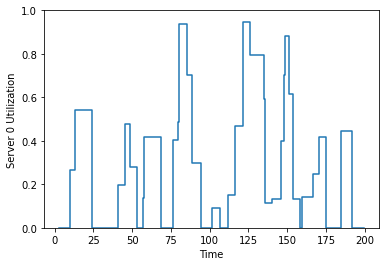

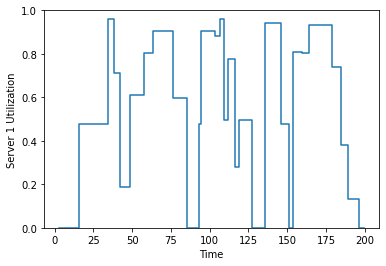

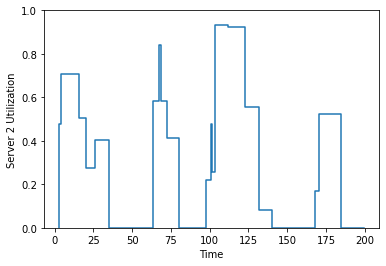

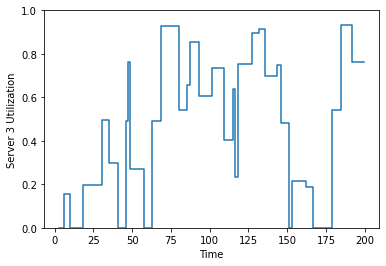

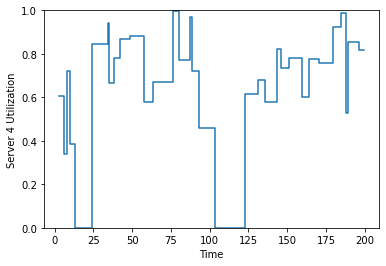

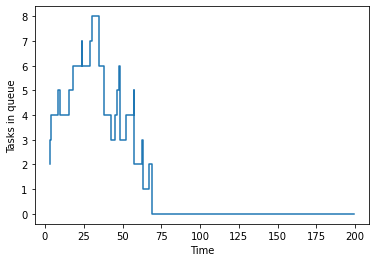

In [12]:
# activate the simulation environment
actuate = TaskGenerator(sim_env)
sim_env.process(actuate.generate_task())

# run the simulation  until 200 time units
sim_env.run(until=200)

# plot the cpu utilization
for i in range(number_of_nodes):
    plt.figure()
    plt.step(simulation_time_append, util[i])
    plt.xlabel("Time")
    plt.ylim([0, 1])
    plt.ylabel(f"Server {i} Utilization")

# plot the tasks in queue
plt.figure()
plt.step(simulation_time_append, tasks_in_queue_append)
plt.xlabel("Time")
plt.ylabel("Tasks in queue")